In [1]:
import torch as t
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision

/home/p/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

train_images,train_labels = trainset.train_data, np.array(trainset.train_labels)
train_images = torch.from_numpy(np.expand_dims(train_images, axis=1)).float()

validset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

valid_images,valid_labels = validset.test_data, np.array(validset.test_labels)
valid_images = torch.from_numpy(np.expand_dims(valid_images, axis=1)).float()


/home/p/.local/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/p/.local/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/p/.local/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/p/.local/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [30]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

    
models = [[torch.load(f'final_model_ckpt{i}.{j}.pt', map_location=torch.device('cpu')).eval() for j in range(10)] for i in range(5)]


In [33]:
acc = [np.array([(models[i][j](valid_images).argmax(dim=-1).detach().numpy() == valid_labels).sum() / len(valid_labels) for i in range(5)]) for j in range(10)]

In [36]:
preds = []
for j in range(10):
    pred = [models[i][j](train_images) for i in range(5)]
    pred = torch.cat(pred, dim=-1)
    preds.append(pred)

In [38]:
from sklearn.ensemble import AdaBoostClassifier
abc_acc = []
for j in range(10):
    clf_abc = AdaBoostClassifier()
    clf_abc.fit(preds[j].detach().numpy(), train_labels)
    abc_acc.append((clf_abc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()) == valid_labels).sum() / len(valid_labels))
    

In [39]:
from sklearn.ensemble import BaggingClassifier
bc_acc = []
for j in range(10):
    clf_bc = BaggingClassifier()
    clf_bc.fit(preds[j].detach().numpy(), train_labels)
    bc_acc.append((clf_bc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()) == valid_labels).sum() / len(valid_labels))

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
etc_acc = []
for j in range(10):
    clf_etc = ExtraTreesClassifier()
    clf_etc.fit(preds[j].detach().numpy(), train_labels)
    etc_acc.append((clf_etc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()) == valid_labels).sum() / len(valid_labels))

In [42]:
from sklearn.ensemble import RandomForestClassifier

rfc_acc = []
for j in range(10):
    clf_rfc = RandomForestClassifier()
    clf_rfc.fit(preds[j].detach().numpy(), train_labels)
    rfc_acc.append((clf_rfc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()) == valid_labels).sum() / len(valid_labels))

In [43]:
from sklearn.ensemble import HistGradientBoostingClassifier
gbc_acc = []
for j in range(10):
    clf_gbc = HistGradientBoostingClassifier()
    clf_gbc.fit(preds[j].detach().numpy(), train_labels)
    gbc_acc.append((clf_gbc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()) == valid_labels).sum() / len(valid_labels))

In [107]:
vote_acc = []
for j in range(10):
    vote_acc.append((torch.stack([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy().sum(axis=-1).argmax(axis=-1) == valid_labels).sum() / len(valid_labels))

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
accuracies = pd.DataFrame({'FL': [a.mean() for a in acc], 'FL + Random Forest': rfc_acc, 'FL + AdaBoost': abc_acc, 'FL + Bagging': bc_acc, 'FL + ExtraTrees': etc_acc, 'FL + RandomForest': rfc_acc, 'FL + GradientBoosting': gbc_acc, 'FL + Voting': vote_acc}).transpose()
accuracies.index.name = 'method'
accuracies = accuracies.reset_index()
accuracies = pd.melt(accuracies, id_vars='method', var_name='round', value_name='accuracy')
accuracies['accuracy_gamma'] = accuracies['accuracy'].apply(lambda x: np.power(x, 10))
accuracies['accuracy'] *= 100


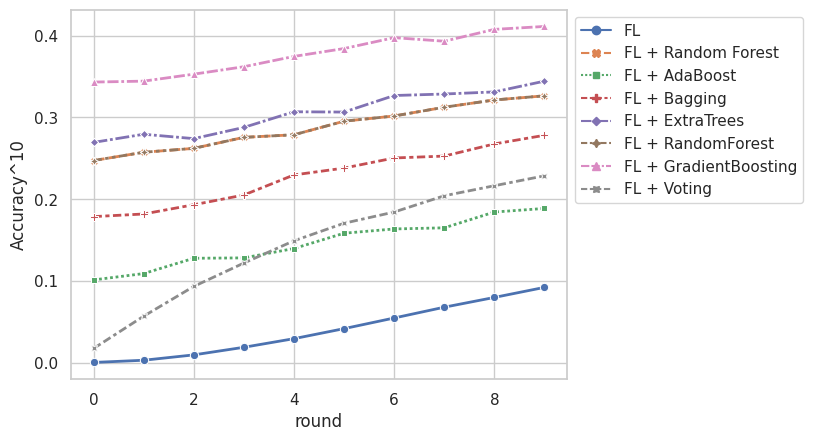

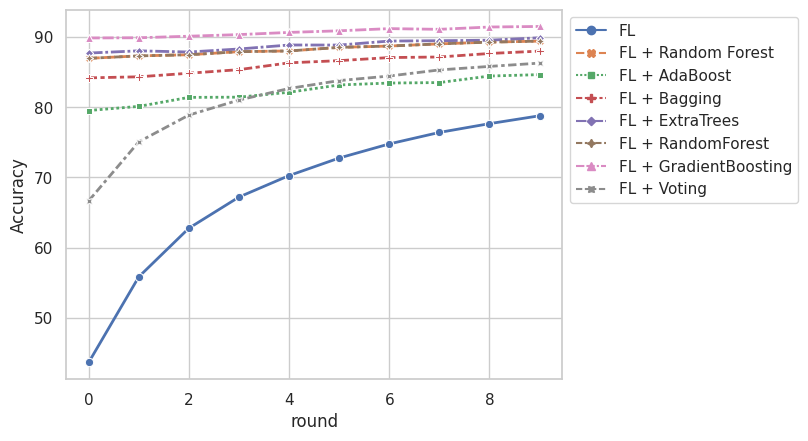

In [210]:
sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=accuracies, y='accuracy_gamma', x='round', hue='method',  linewidth=2, style="method", markers=True)
plt.ylabel("Accuracy^10")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
ax = sns.lineplot(data=accuracies, y='accuracy', x='round', hue='method',  linewidth=2, style="method", markers=True)
plt.ylabel("Accuracy")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


(50.0, 100.0)

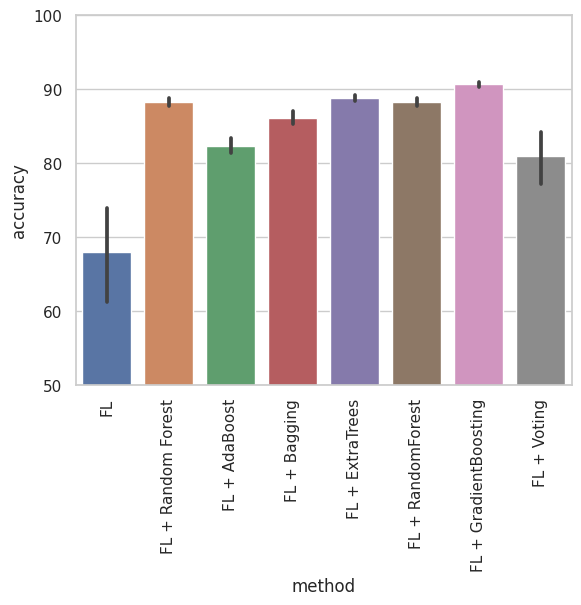

In [192]:
ax = sns.barplot(data=accuracies, y='accuracy', x='method')
plt.xticks(rotation=90)
ax.set_ylim(50,  100)

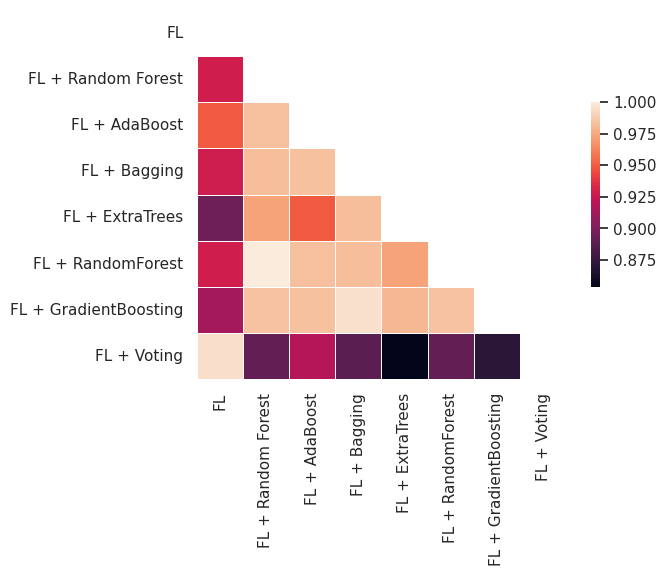

<AxesSubplot:>

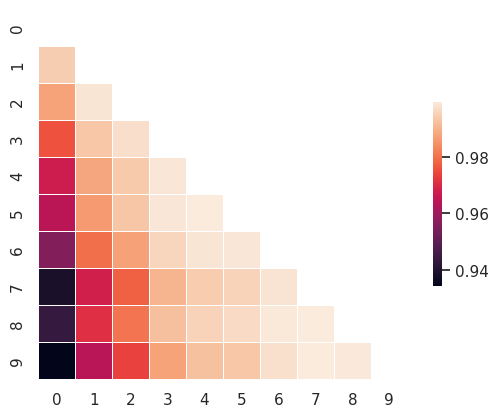

In [218]:
df = pd.DataFrame({'FL': [a.mean() for a in acc], 'FL + Random Forest': rfc_acc, 'FL + AdaBoost': abc_acc, 'FL + Bagging': bc_acc, 'FL + ExtraTrees': etc_acc, 'FL + RandomForest': rfc_acc, 'FL + GradientBoosting': gbc_acc, 'FL + Voting': vote_acc})
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()
corr = df.transpose().corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": .5})

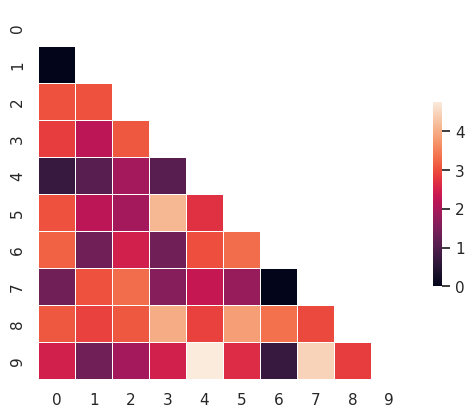

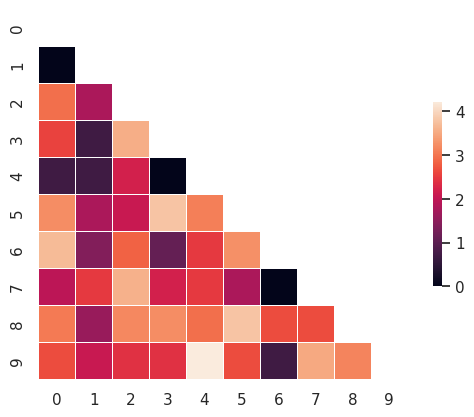

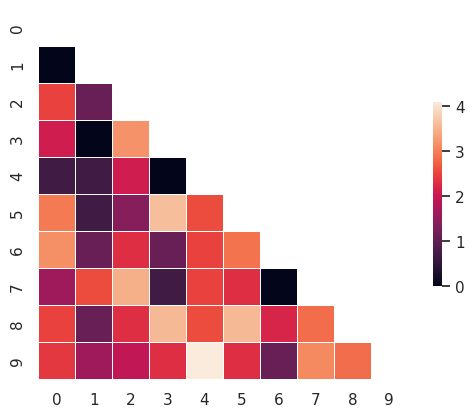

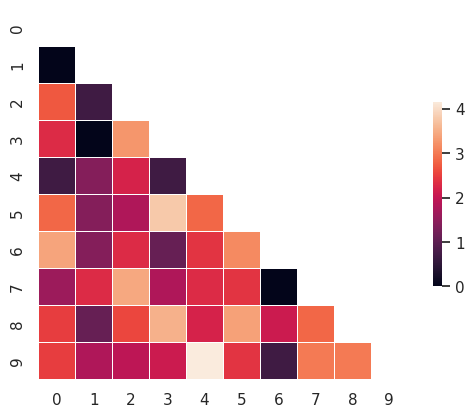

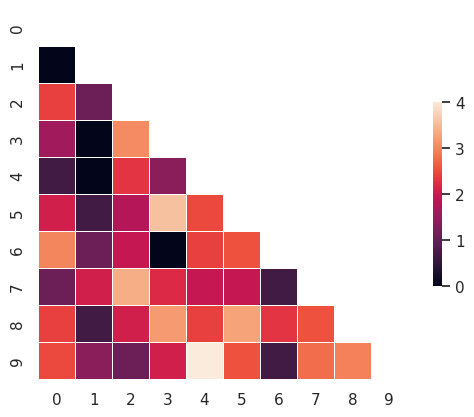

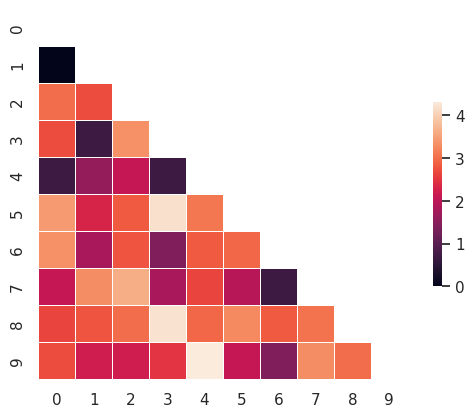

In [209]:
from sklearn.metrics import confusion_matrix
sns.heatmap(np.log(1+confusion_matrix(valid_labels, clf_abc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()))), square=True, linewidths=.5, cbar_kws={"shrink": .5}, mask = np.triu(np.ones((10,10), dtype=bool)))
plt.show()
sns.heatmap(np.log(1+confusion_matrix(valid_labels, clf_bc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()))), square=True, linewidths=.5, cbar_kws={"shrink": .5}, mask = np.triu(np.ones((10,10), dtype=bool)))
plt.show()
sns.heatmap(np.log(1+confusion_matrix(valid_labels, clf_etc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()))), square=True, linewidths=.5, cbar_kws={"shrink": .5}, mask = np.triu(np.ones((10,10), dtype=bool)))
plt.show()
sns.heatmap(np.log(1+confusion_matrix(valid_labels, clf_rfc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()))), square=True, linewidths=.5, cbar_kws={"shrink": .5}, mask = np.triu(np.ones((10,10), dtype=bool)))
plt.show()
sns.heatmap(np.log(1+confusion_matrix(valid_labels, clf_gbc.predict(torch.cat([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy()))), square=True, linewidths=.5, cbar_kws={"shrink": .5}, mask = np.triu(np.ones((10,10), dtype=bool)))
plt.show()
sns.heatmap(np.log(1+confusion_matrix(valid_labels, torch.stack([models[i][j](valid_images) for i in range(5)], dim=-1).detach().numpy().sum(axis=-1).argmax(axis=-1))), square=True, linewidths=.5, cbar_kws={"shrink": .5}, mask = np.triu(np.ones((10,10), dtype=bool)))
plt.show()


In [219]:
{'FL': [a.mean() for a in acc], 'FL + Random Forest': rfc_acc, 'FL + AdaBoost': abc_acc, 'FL + Bagging': bc_acc, 'FL + ExtraTrees': etc_acc, 'FL + RandomForest': rfc_acc, 'FL + GradientBoosting': gbc_acc, 'FL + Voting': vote_acc}

{'FL': [0.43658,
  0.55846,
  0.6277200000000001,
  0.6720799999999999,
  0.70266,
  0.72766,
  0.7477400000000001,
  0.7641,
  0.7766,
  0.78782],
 'FL + Random Forest': [0.8696,
  0.8731,
  0.8747,
  0.8791,
  0.8801,
  0.8852,
  0.8871,
  0.8902,
  0.8927,
  0.8941],
 'FL + AdaBoost': [0.7953,
  0.8012,
  0.814,
  0.8143,
  0.8213,
  0.8317,
  0.8344,
  0.8351,
  0.8444,
  0.8464],
 'FL + Bagging': [0.8418,
  0.8433,
  0.8484,
  0.8535,
  0.8632,
  0.8663,
  0.8707,
  0.8715,
  0.8765,
  0.8799],
 'FL + ExtraTrees': [0.8771,
  0.8803,
  0.8786,
  0.8829,
  0.8886,
  0.8885,
  0.8942,
  0.8947,
  0.8954,
  0.8989],
 'FL + RandomForest': [0.8696,
  0.8731,
  0.8747,
  0.8791,
  0.8801,
  0.8852,
  0.8871,
  0.8902,
  0.8927,
  0.8941],
 'FL + GradientBoosting': [0.8986,
  0.8989,
  0.9011,
  0.9034,
  0.9065,
  0.9088,
  0.9119,
  0.9109,
  0.9142,
  0.915],
 'FL + Voting': [0.6667,
  0.7507,
  0.7888,
  0.8102,
  0.8267,
  0.8379,
  0.8444,
  0.8531,
  0.8581,
  0.8628]}